In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import scikit_posthocs as sp
# import scipy.stats as stats
from sklearn import preprocessing
# from sklearn.metrics import r2_score

# from statsmodels.stats.multicomp import MultiComparison
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
# from sklearn.model_selection import GridSearchCV


# from scipy.stats import linregress
# from sklearn.decomposition import PCA

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# from sklearn.decomposition import PCA, KernelPCA

# Leitura de DataSet
Estamos trabalhando com o DataFrame de pacientes que possuem, originalmente, pelo menos um valor dos seguintes exames:

- Albumina;
- Microalbuminuria;
- Rel.AlbuminaCreatininaUAUC;
- Proteinuria24hs;


Entre os exames, nenhum destes possuem valores nulos, estes valor foram preenchidos com a média dos mesmos. 

In [3]:
df = pd.read_csv('datasets/banco_por_semestre_imputado.csv', sep = ',', encoding = "ISO-8859-1", low_memory = False, 
                 error_bad_lines=False).drop(['Unnamed: 0'], axis=1,errors='ignore')


# passando algumas colunas mais importantes para inteiroA
df['Raça'].replace(['Branca','Parda','Preta','Indigena','Amarela'],[1,2,3,4,5], inplace=True)
df['tabagismo'].replace(['Ex','Sim'],[0,1], inplace=True)
df['Codsexo'].replace(['Feminino','Masculino'],[1,2], inplace=True)

#ao invés de mexermos com o estágio final, iremos analisar o estágio do semstre
df["SEMESTRE"].replace(df["SEMESTRE"].unique(),[2010.0, 2011.1, 2011.2, 2012.1, 2012.2, 2013.1, 2013.2,
       2014.1, 2014.2, 2015.0], inplace=True)
df["Estagio_EQ"].replace({'Estágio 2 - 60-89 ml':2, 'Estágio 3a - 45-59 ml':3,
                           'Estágio 1 - >= 90 ml':1, 'Estágio 5 - < 15 ml':6,
                           'Estágio 3b - 30-44 ml':4, 'Estágio 4 - 15-29 ml':5}, inplace=True)

df['etilismo'].replace(['Ex','Sim'],[0,1], inplace=True)
df['sedentario'].replace(['Não','Sim'],[0,1], inplace=True)
df['insulina'].replace(['Não','Sim'],[0,1], inplace=True)

#index de pacientes que possuem albumina
df_alb = pd.read_csv('datasets/banco_por_semestre.csv', sep = ',', encoding = "ISO-8859-1", low_memory = False, 
                 error_bad_lines=False).drop(['Unnamed: 0'], axis=1,errors='ignore')
index_albumina = [i for i in df_alb.dropna(subset=['Albumina']).index]

#dataframe, já preenchido, apenas com os pacientes que possuem os exames citados
albumina_pacientes = df.iloc[(df_alb['Albumina'].isna()==False).values]
microalbuminuria_pacientes= df.iloc[(df_alb['Microalbuminuria'].isna()==False).values]
relAlbCrea_pacientes= df.iloc[(df_alb['Rel.AlbuminaCreatininaUAUC'].isna()==False).values]
proteinuria_pacientes= df.iloc[(df_alb['Proteinuria24hs'].isna()==False).values]


#juntando os dataframes
df_pacientes_exames = pd.concat([albumina_pacientes,microalbuminuria_pacientes,relAlbCrea_pacientes,
                                proteinuria_pacientes]).drop_duplicates()

# Formar Grupos 
Iremos utilizar o algoritmo Kmeans para formar grupos, reduzindo os exames em duas componentes.

### Gráfico

In [4]:
def grafico(finalDf,df):
    #renomeando index
    tuple_index=[]
    for i in range(len(finalDf)):
        tuple_index.append((df.index[i],i))
    finalDf.rename(index={velho:novo for velho,novo in tuple_index},inplace=True)
    #Visualização
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)    
    ax.set_title('2 component TSNE with Euclidean metric', fontsize = 20)
    targets = finalDf['Estagio_EQ'].unique()
    colors ={1:'green',2:'yellow',3:'orange',4:'red',5:'crimson',6:'blue'}
    for target in targets:
        indicesToKeep = finalDf['Estagio_EQ'] == target
        color = colors[target]
        ax.scatter(finalDf.loc[indicesToKeep, 'Component 1']
                   , finalDf.loc[indicesToKeep, 'Component 2']
                   , c = color
                   , s = 90)
    ax.legend(targets,title='Stages')
    ax.grid() 

In [5]:
def grafico_tnse(finalDf):
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)    
    ax.set_title('2 component TSNE with Euclidean metric', fontsize = 20)

    targets = finalDf['Estagio_EQ'].unique()
    colors ={1:'green',2:'yellow',3:'orange',4:'red',5:'c',6:'blue'}
    for target in targets:
        indicesToKeep = finalDf['Estagio_EQ'] == target
        color = colors[target]
        ax.scatter(finalDf.loc[indicesToKeep,'Component 1']
                   , finalDf.loc[indicesToKeep, 'Component 2']
                   , c = color
                   , s = 90)

    ax.legend(targets,title='Stages')
    ax.grid()

In [6]:
# import chart_studio.plotly as py
import plotly as py
import plotly.graph_objs as go
def visualizacao_3d(df):

    X = df.drop(columns=['Estagio_EQ','Albumina_Estagio'])
    y = df['Estagio_EQ']
    
    #T-SNE
    tsne = TSNE(n_components=3,metric='euclidean')
    Xt = tsne.fit_transform(X)

    df_Xt = pd.DataFrame(Xt,columns=['Componente 1', 'Componente 2', 'Componente 3'],index=X.index)

    xtrain, xtest, ytrain, ytest = train_test_split(df_Xt,
                                                    y, test_size=0.30,
                                                    random_state=42)
    df_Xt['Estagio_EQ'] =y.values
    
    trace1 = go.Scatter3d(
        x= df_Xt['Componente 1'],
        y= df_Xt['Componente 2'],
        z= df_Xt['Componente 3'],
        mode='markers',
        marker=dict(
            color = df_Xt['Estagio_EQ'], 
            size=2,
            line=dict(
                color= df_Xt['Estagio_EQ'],
                width= 1
            ),
            opacity=1.0
         )
    )
    data = [trace1]
    layout = go.Layout(
        title= 'Clusters',
        scene = dict(
                xaxis = dict(title  = 'Componente 1'),
                yaxis = dict(title  = 'Componente 2'),
                zaxis = dict(title  = 'Componente 3')
            )
    )
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ), showlegend=True)
    py.offline.iplot(fig)

### TSNE e Kmeans

In [7]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import homogeneity_score,completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
def tsne_tests(df,numk):
    X = df.drop(columns=['Estagio_EQ'])#,'Albumina_Estagio'
    y = df['Estagio_EQ']
    
    #T-SNE
    tsne = TSNE(n_components=2,metric='euclidean')
    Xt = tsne.fit_transform(X)

    df_Xt = pd.DataFrame(Xt,columns=['Component 1', 'Component 2'],index=X.index)

    
    df_Xt['Estagio_EQ'] =y.values


    #separando em conjunto de teste e de treino
    xtrain, xtest, ytrain, ytest = train_test_split(df_Xt.drop('Estagio_EQ',axis=1),
                                                    y, test_size=0.30,
                                                    random_state=42)
    
    #kmeans, labels será o Estagio TFG com T-SNE
    k=numk
    kmeans = KMeans(init='k-means++',n_clusters = k,random_state=42).fit(xtrain)
    ypred = kmeans.predict(xtest)
    

    #clustering performance evaluation
    silhoutte_erro = silhouette_score(xtest, ypred, metric = 'euclidean')
    calinski_erro = calinski_harabasz_score(xtest,ypred)
    homogeneity =  homogeneity_score(ytest, ypred)
    
    completeness = completeness_score(ytest, ypred)
    v_measure =  v_measure_score(ytest, ypred)
    adjusted_rand = adjusted_rand_score(ytest, ypred)
    adjusted_mutual = adjusted_mutual_info_score(ytest, ypred)

    
    print("k={0}, Silhouette score={1}, Calinski harabasz score={2}\n".format(k,silhoutte_erro, calinski_erro))
    print("completeness_score={0}, v_measure={1}, adjusted_rand={2}, adjusted_mutual ={3}".format(completeness,
                                                                       v_measure, adjusted_rand,adjusted_mutual))
    print('\n Homogeneity:{0}'.format(homogeneity))

    
    #elbow
    kmeans_el = KMeans(init='k-means++',random_state=42)
    visualizer = KElbowVisualizer(kmeans_el, k=np.arange(2,12,1))
    visualizer.fit(xtrain)        
    visualizer.show() 
    

    finalDf = pd.concat([xtest,
                         pd.DataFrame(ypred, 
                                      index=xtest.index,
                                      columns=['Estagio_EQ'])], 
                         axis = 1)
    finalDf['Estagio_EQ'].replace({0:1,1:2,2:3,3:4,4:5,5:6},inplace=True)

    aux = pd.DataFrame(data =finalDf['Estagio_EQ'].values,
                              columns=['ypred'],
                              index=xtest.index)

    df_estagio = pd.concat([aux,pd.DataFrame(ytest.values, 
                                      index=ytest.index,
                                      columns=['ytest'])],axis=1)
    grafico(finalDf,df_estagio)
    return df_estagio,df_Xt

# Testes com os exames mais importantes e Correlação

## Teste1:

Todos+Hemoglobina+Ureia+Creatinina+Ácido Úrico

In [13]:
#verificar se todos esses exames existem no dataset
exames =['PAS','PAD' , 
       'ColesterolTotal', 'GlicemiadeJejum', 'Triglicerides', 
       'Potassio', 'ColesterolHDL', 'TSH',
       'HemoglobinaGlicada', 'TGP',
       'Albumina','Microalbuminuria','AcidoUrico', 'Ureia',
       'Rel.AlbuminaCreatininaUAUC','Proteinuria24hs',
       'Codsexo', 'Idade', 'Raça', 'Creatinina','Hemoglobina',
       'Estagio_EQ']#'etilismo', 'sedentario','tabagismo','Codsexo', 'Idade', 'Raça', 'pesoi', 'pesof''AcidoUrico' 'Ureia',
        #'Albumina_Estagio''Creatinina',, 'pesoi''Hemoglobina','etilismo', 'sedentario','tabagismo',
#colcocar em um dataframe
df_verificar_estagio = pd.DataFrame(index=df_pacientes_exames.index, columns = exames)
for i in exames:
    df_verificar_estagio[i] = df_pacientes_exames[i]
# df_verificar_estagio.isna().any()
df_verificar_estagio.rename(columns={'Rel.AlbuminaCreatininaUAUC':'Rel_AlbuminaCreatininaUAUC'},inplace=True)


In [17]:
#normalização dos dados
scaler = preprocessing.MinMaxScaler( feature_range=(0,1) )    
df_exames_norm = scaler.fit_transform(df_verificar_estagio)
#inserir os estagios no exames
df_exames_norm = pd.DataFrame(df_exames_norm,columns=exames,index=df_verificar_estagio.index)

# Inserindo os estágios
df_exames_norm['Estagio_EQ'] = df_verificar_estagio['Estagio_EQ']
df_exames_norm

,PAS,PAD,ColesterolTotal,GlicemiadeJejum,Triglicerides,Potassio,ColesterolHDL,TSH,HemoglobinaGlicada,TGP,...,AcidoUrico,Ureia,Rel.AlbuminaCreatininaUAUC,Proteinuria24hs,Codsexo,Idade,Raça,Creatinina,Hemoglobina,Estagio_EQ
52,0.410227,0.060663,0.134867,0.124995,0.087425,0.45125,0.395483,0.021350,0.272641,0.041714,...,0.428198,0.056191,0.001189,0.006964,0.0,0.572917,0.00,0.099121,0.577191,4
60,0.515152,0.091837,0.243878,0.086528,0.103888,0.37500,0.537815,0.025118,0.448554,0.022177,...,0.360313,0.095643,0.012826,0.010105,0.0,0.583333,0.00,0.116211,0.509968,5
210,0.549242,0.084694,0.130612,0.075005,0.040790,0.46250,0.695378,0.050549,0.331437,0.036290,...,0.321149,0.120615,0.011222,0.009657,0.0,0.687500,0.00,0.086914,0.528512,4
235,0.380606,0.068459,0.195194,0.177519,0.024162,0.54625,0.435609,0.028362,0.300616,0.016452,...,0.496084,0.156287,0.040194,0.013073,0.0,0.645833,0.00,0.086426,0.557255,4
300,0.454545,0.105102,0.283673,0.235282,0.181644,0.35000,0.548319,0.012559,0.416785,0.034617,...,0.419060,0.080714,0.023627,0.000129,0.0,0.406250,0.50,0.023926,0.505331,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56399,0.393939,0.081633,0.333673,0.119003,0.295730,0.46625,0.411765,0.067085,0.331437,0.062923,...,0.315927,0.088579,0.008910,0.000004,0.0,0.687500,0.25,0.079102,0.556328,6
56599,0.469697,0.081633,0.135714,0.137859,0.091778,0.45000,0.411765,0.005651,0.350403,0.064516,...,0.223238,0.038924,0.011478,0.006545,1.0,0.447917,0.00,0.041016,0.579509,5
56629,0.469697,0.071429,0.137755,0.100147,0.050351,0.58750,0.432773,0.008216,0.412044,0.024194,...,0.229765,0.056543,0.019899,0.004760,0.0,0.677083,0.00,0.048340,0.421882,1
56718,0.356061,0.081633,0.190816,0.097004,0.078394,0.36250,0.485294,0.035165,0.265055,0.095726,...,0.210183,0.038924,0.003677,0.000024,0.0,0.552083,0.25,0.032227,0.519240,1


### Correlação

In [18]:
import sweetviz as sv

report =sv.analyze(df_verificar_estagio,"Estagio_EQ",sv.FeatureConfig(force_num=["Estagio_EQ"]))
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Resultados do Teste 1 - Tsne e Kmeans

k=6, Silhouette score=0.5896090865135193, Calinski harabasz score=5547.069620333867

completeness_score=0.009514817707934548, v_measure=0.009607605065752868, adjusted_rand=0.0017232227936247334, adjusted_mutual =0.006888643351755237

 Homogeneity:0.00970221994767183


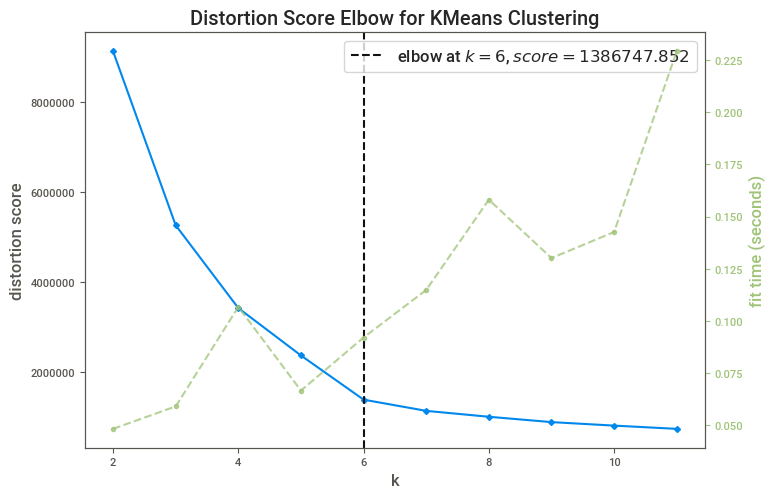

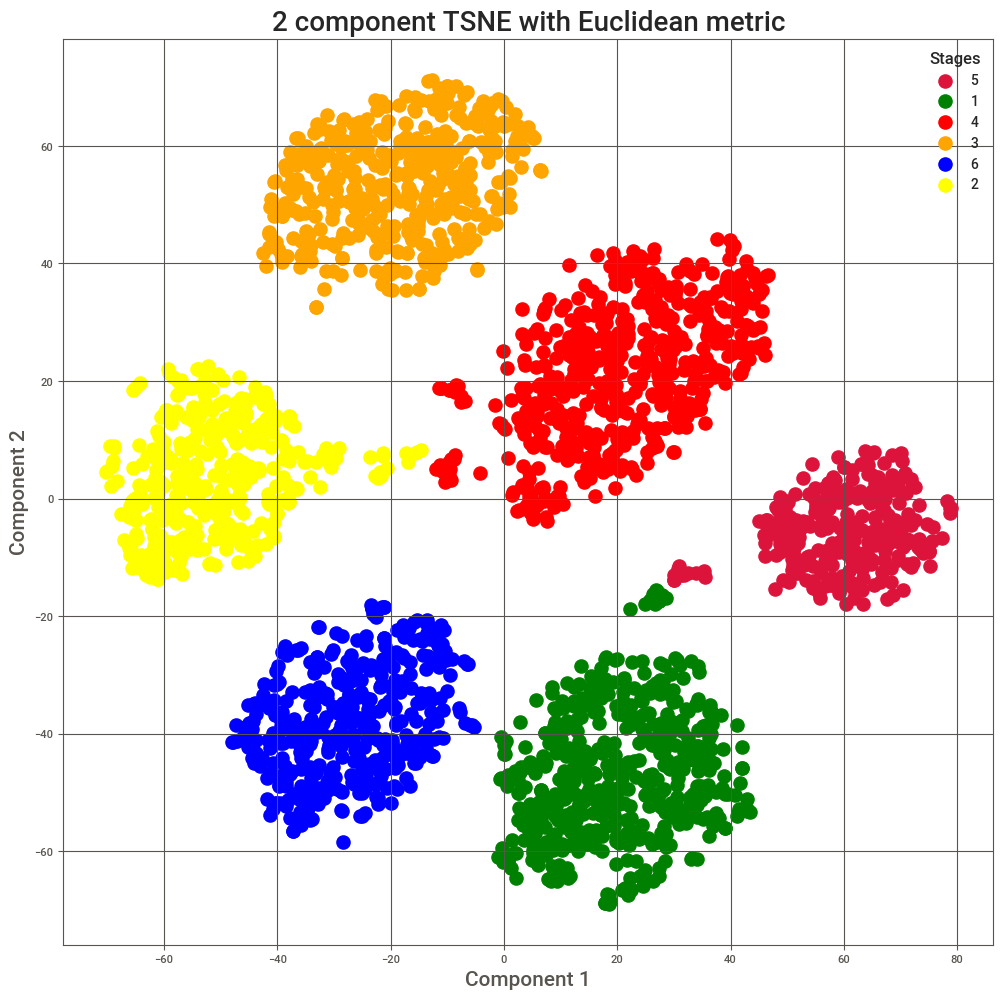

In [19]:
df_comparar_resultados,df_Xt = tsne_tests(df_exames_norm,6)

## Teste2:

- Todos+Hemoglobina+Ureia+Creatinina+Ácido Úrico;
- Todos+Hemoglobina+Ureia+Ácido Úrico;

In [24]:
#copiar o dataframe com todos os exames e retirar a Creatinina
df_sem_creatina=df_exames_norm.drop(['Creatinina'],axis=1)
df_sem_creatina

,PAS,PAD,ColesterolTotal,GlicemiadeJejum,Triglicerides,Potassio,ColesterolHDL,TSH,HemoglobinaGlicada,TGP,...,Microalbuminuria,AcidoUrico,Ureia,Rel.AlbuminaCreatininaUAUC,Proteinuria24hs,Codsexo,Idade,Raça,Hemoglobina,Estagio_EQ
52,0.410227,0.060663,0.134867,0.124995,0.087425,0.45125,0.395483,0.021350,0.272641,0.041714,...,0.049304,0.428198,0.056191,0.001189,0.006964,0.0,0.572917,0.00,0.577191,4
60,0.515152,0.091837,0.243878,0.086528,0.103888,0.37500,0.537815,0.025118,0.448554,0.022177,...,0.001185,0.360313,0.095643,0.012826,0.010105,0.0,0.583333,0.00,0.509968,5
210,0.549242,0.084694,0.130612,0.075005,0.040790,0.46250,0.695378,0.050549,0.331437,0.036290,...,0.008041,0.321149,0.120615,0.011222,0.009657,0.0,0.687500,0.00,0.528512,4
235,0.380606,0.068459,0.195194,0.177519,0.024162,0.54625,0.435609,0.028362,0.300616,0.016452,...,0.003196,0.496084,0.156287,0.040194,0.013073,0.0,0.645833,0.00,0.557255,4
300,0.454545,0.105102,0.283673,0.235282,0.181644,0.35000,0.548319,0.012559,0.416785,0.034617,...,0.004542,0.419060,0.080714,0.023627,0.000129,0.0,0.406250,0.50,0.505331,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56399,0.393939,0.081633,0.333673,0.119003,0.295730,0.46625,0.411765,0.067085,0.331437,0.062923,...,0.032330,0.315927,0.088579,0.008910,0.000004,0.0,0.687500,0.25,0.556328,6
56599,0.469697,0.081633,0.135714,0.137859,0.091778,0.45000,0.411765,0.005651,0.350403,0.064516,...,0.030172,0.223238,0.038924,0.011478,0.006545,1.0,0.447917,0.00,0.579509,5
56629,0.469697,0.071429,0.137755,0.100147,0.050351,0.58750,0.432773,0.008216,0.412044,0.024194,...,0.032776,0.229765,0.056543,0.019899,0.004760,0.0,0.677083,0.00,0.421882,1
56718,0.356061,0.081633,0.190816,0.097004,0.078394,0.36250,0.485294,0.035165,0.265055,0.095726,...,0.006994,0.210183,0.038924,0.003677,0.000024,0.0,0.552083,0.25,0.519240,1


### Correlação

In [25]:
report =sv.analyze(df_sem_creatina,"Estagio_EQ",sv.FeatureConfig(force_num=["Estagio_EQ"]))
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Resultados do Teste 2 - Tsne e Kmeans

k=6, Silhouette score=0.6131220459938049, Calinski harabasz score=5795.229443111578

completeness_score=0.009954123028669949, v_measure=0.010049316315756295, adjusted_rand=0.0016170530432086196, adjusted_mutual =0.007331019557146724

 Homogeneity:0.01014634788795955


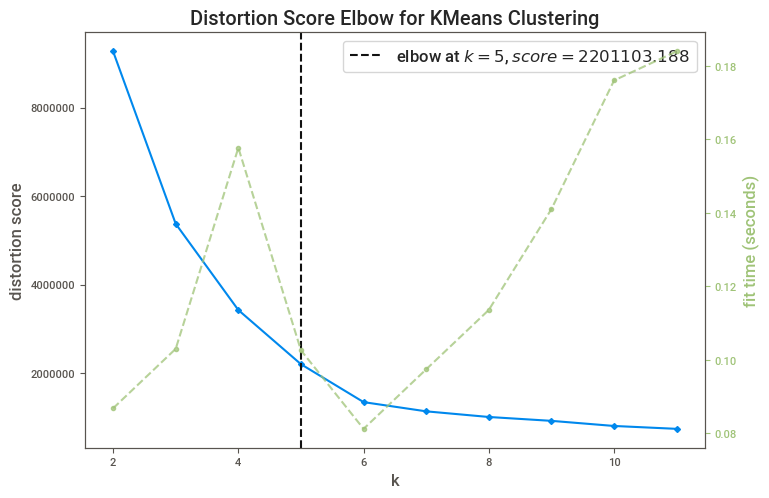

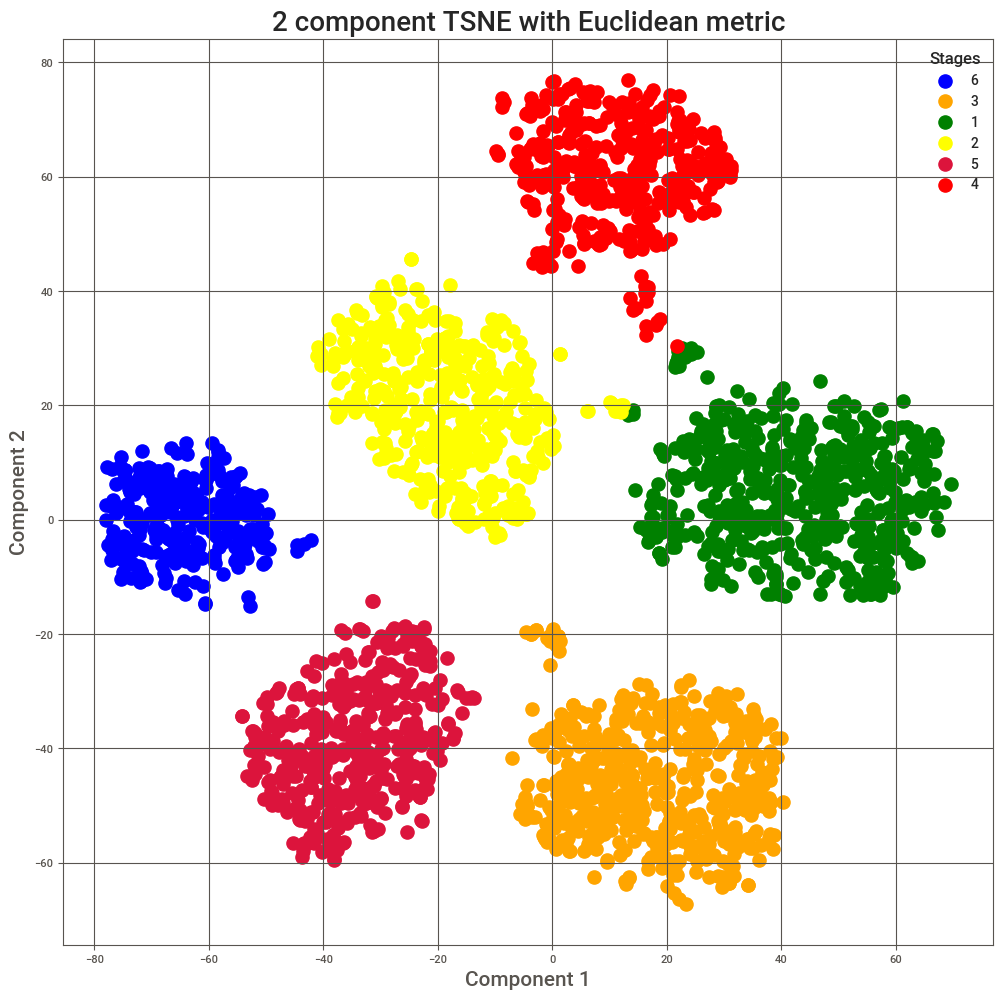

In [26]:
df_comparar_resultados,df_Xt = tsne_tests(df_sem_creatina,6)

## Teste3:

- Todos+Hemoglobina+Ureia+Creatinina+Ácido Úrico;
- Todos+Hemoglobina+Ureia+Ácido Úrico;
- Todos+Hemoglobina;

In [37]:
#copiar o dataframe com todos os exames e retirar a Creatinina,Ureia,AcidoUrico
df_hemoglobina=df_exames_norm.drop(['Creatinina','Ureia','AcidoUrico'],axis=1)
df_hemoglobina

,PAS,PAD,ColesterolTotal,GlicemiadeJejum,Triglicerides,Potassio,ColesterolHDL,TSH,HemoglobinaGlicada,TGP,Albumina,Microalbuminuria,Rel.AlbuminaCreatininaUAUC,Proteinuria24hs,Codsexo,Idade,Raça,Hemoglobina,Estagio_EQ
52,0.410227,0.060663,0.134867,0.124995,0.087425,0.45125,0.395483,0.021350,0.272641,0.041714,0.561404,0.049304,0.001189,0.006964,0.0,0.572917,0.00,0.577191,4
60,0.515152,0.091837,0.243878,0.086528,0.103888,0.37500,0.537815,0.025118,0.448554,0.022177,0.596491,0.001185,0.012826,0.010105,0.0,0.583333,0.00,0.509968,5
210,0.549242,0.084694,0.130612,0.075005,0.040790,0.46250,0.695378,0.050549,0.331437,0.036290,0.526316,0.008041,0.011222,0.009657,0.0,0.687500,0.00,0.528512,4
235,0.380606,0.068459,0.195194,0.177519,0.024162,0.54625,0.435609,0.028362,0.300616,0.016452,0.719298,0.003196,0.040194,0.013073,0.0,0.645833,0.00,0.557255,4
300,0.454545,0.105102,0.283673,0.235282,0.181644,0.35000,0.548319,0.012559,0.416785,0.034617,0.456140,0.004542,0.023627,0.000129,0.0,0.406250,0.50,0.505331,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56399,0.393939,0.081633,0.333673,0.119003,0.295730,0.46625,0.411765,0.067085,0.331437,0.062923,0.550877,0.032330,0.008910,0.000004,0.0,0.687500,0.25,0.556328,6
56599,0.469697,0.081633,0.135714,0.137859,0.091778,0.45000,0.411765,0.005651,0.350403,0.064516,0.480702,0.030172,0.011478,0.006545,1.0,0.447917,0.00,0.579509,5
56629,0.469697,0.071429,0.137755,0.100147,0.050351,0.58750,0.432773,0.008216,0.412044,0.024194,0.515789,0.032776,0.019899,0.004760,0.0,0.677083,0.00,0.421882,1
56718,0.356061,0.081633,0.190816,0.097004,0.078394,0.36250,0.485294,0.035165,0.265055,0.095726,0.531579,0.006994,0.003677,0.000024,0.0,0.552083,0.25,0.519240,1


### Correlação

In [29]:
report =sv.analyze(df_hemoglobina,"Estagio_EQ",sv.FeatureConfig(force_num=["Estagio_EQ"]))
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Resultados do Teste 3 - Tsne e Kmeans

k=6, Silhouette score=0.6105377674102783, Calinski harabasz score=5746.07058047509

completeness_score=0.010251980983656641, v_measure=0.010350788110390278, adjusted_rand=0.0017900054310930327, adjusted_mutual =0.007633523763754837

 Homogeneity:0.010451518349725141


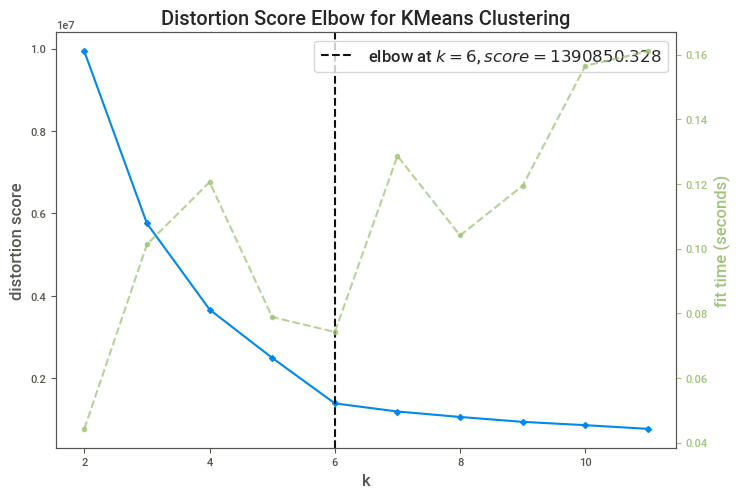

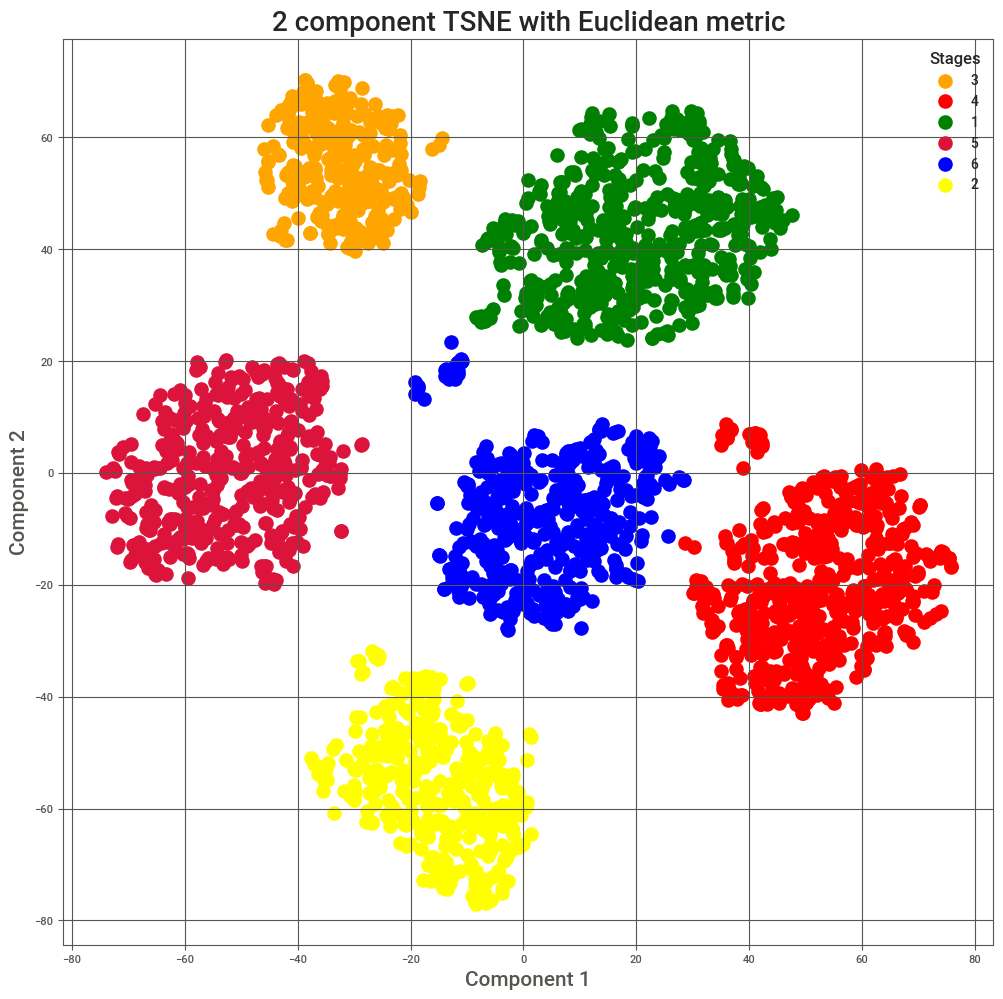

In [38]:
df_comparar_resultados,df_Xt = tsne_tests(df_hemoglobina,6)

## Teste4:

- Todos+Hemoglobina+Ureia+Creatinina+Ácido Úrico;
- Todos+Hemoglobina+Ureia+Ácido Úrico;
- Todos+Hemoglobina;
- Todos+Hemoglobina-(4 exames relacionados com a albumina -[CodSexo,Idade,Raça,Creatinina])

In [32]:
#copiar o dataframe com todos os exames e retirar a Creatinina,CodSexo
df_4exames=df_exames_norm.drop(['Creatinina','Codsexo','Idade','Raça'],axis=1)
df_4exames

,PAS,PAD,ColesterolTotal,GlicemiadeJejum,Triglicerides,Potassio,ColesterolHDL,TSH,HemoglobinaGlicada,TGP,Albumina,Microalbuminuria,AcidoUrico,Ureia,Rel.AlbuminaCreatininaUAUC,Proteinuria24hs,Hemoglobina,Estagio_EQ
52,0.410227,0.060663,0.134867,0.124995,0.087425,0.45125,0.395483,0.021350,0.272641,0.041714,0.561404,0.049304,0.428198,0.056191,0.001189,0.006964,0.577191,4
60,0.515152,0.091837,0.243878,0.086528,0.103888,0.37500,0.537815,0.025118,0.448554,0.022177,0.596491,0.001185,0.360313,0.095643,0.012826,0.010105,0.509968,5
210,0.549242,0.084694,0.130612,0.075005,0.040790,0.46250,0.695378,0.050549,0.331437,0.036290,0.526316,0.008041,0.321149,0.120615,0.011222,0.009657,0.528512,4
235,0.380606,0.068459,0.195194,0.177519,0.024162,0.54625,0.435609,0.028362,0.300616,0.016452,0.719298,0.003196,0.496084,0.156287,0.040194,0.013073,0.557255,4
300,0.454545,0.105102,0.283673,0.235282,0.181644,0.35000,0.548319,0.012559,0.416785,0.034617,0.456140,0.004542,0.419060,0.080714,0.023627,0.000129,0.505331,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56399,0.393939,0.081633,0.333673,0.119003,0.295730,0.46625,0.411765,0.067085,0.331437,0.062923,0.550877,0.032330,0.315927,0.088579,0.008910,0.000004,0.556328,6
56599,0.469697,0.081633,0.135714,0.137859,0.091778,0.45000,0.411765,0.005651,0.350403,0.064516,0.480702,0.030172,0.223238,0.038924,0.011478,0.006545,0.579509,5
56629,0.469697,0.071429,0.137755,0.100147,0.050351,0.58750,0.432773,0.008216,0.412044,0.024194,0.515789,0.032776,0.229765,0.056543,0.019899,0.004760,0.421882,1
56718,0.356061,0.081633,0.190816,0.097004,0.078394,0.36250,0.485294,0.035165,0.265055,0.095726,0.531579,0.006994,0.210183,0.038924,0.003677,0.000024,0.519240,1


### Correlação

In [33]:
report =sv.analyze(df_4exames,"Estagio_EQ",sv.FeatureConfig(force_num=["Estagio_EQ"]))
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Resultados do Teste 4 - Tsne e Kmeans

k=6, Silhouette score=0.33922362327575684, Calinski harabasz score=2183.25454264986

completeness_score=0.055432095852392914, v_measure=0.056067109750537414, adjusted_rand=0.04038262567674821, adjusted_mutual =0.05348028660105621

 Homogeneity:0.05671684131745025


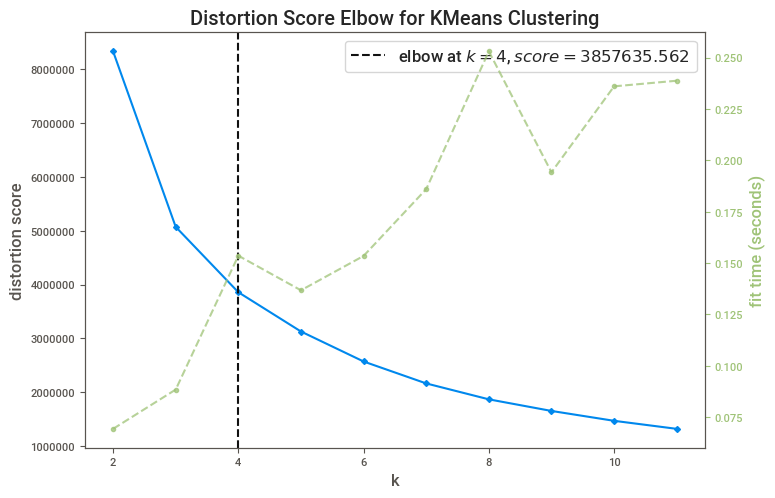

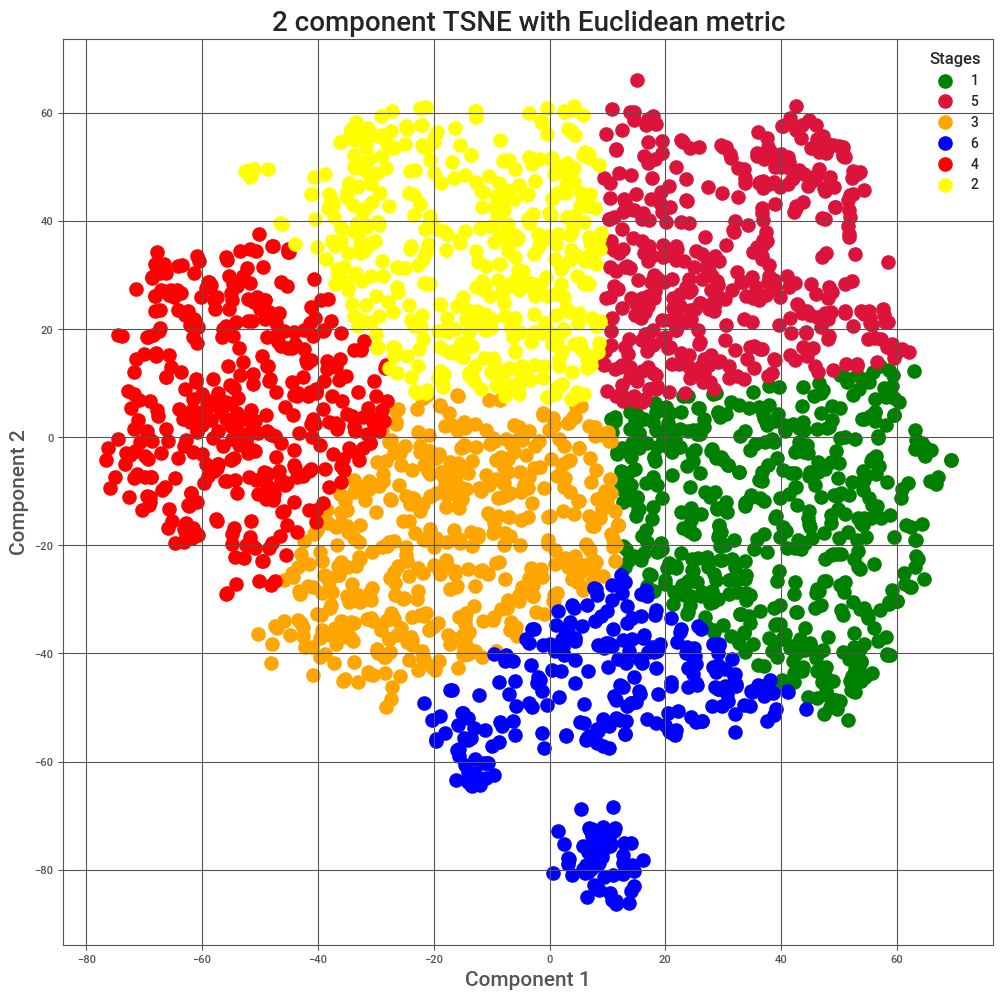

In [34]:
df_comparar_resultados,df_Xt = tsne_tests(df_4exames,6)